In [22]:
!pip install torchxrayvision

In [23]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchxrayvision as xrv
from torch.utils.data.sampler import SubsetRandomSampler

from dataloader import *

In [24]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224)])


d_covid19 = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",
                                   csvpath="covid-chestxray-dataset/metadata.csv",
                                   transform=transform)

d_nih = xrv.datasets.NIH_Dataset(imgpath="nih-dataset/subset-224",
                                 csvpath="nih-dataset/subset.csv")

#Final dataset
covid_dataset = CovidLandmarksDataset(csv_file='./final-dataset/metadata.csv',
                                           root_dir='./final-dataset/images/',
                                      model_type="detection",
                                     transform=transform)

{'ARDS': 0.0,
 'Bacterial Pneumonia': 0.0,
 'COVID-19': 1.0,
 'Chlamydophila': 0.0,
 'Fungal Pneumonia': 0.0,
 'Klebsiella': 0.0,
 'Legionella': 0.0,
 'MERS': 0.0,
 'No Finding': 0.0,
 'Pneumocystis': 0.0,
 'Pneumonia': 1.0,
 'SARS': 0.0,
 'Streptococcus': 0.0,
 'Viral Pneumonia': 1.0}

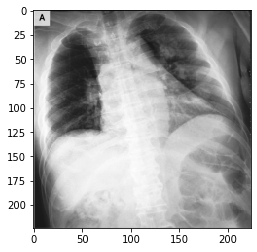

In [25]:
sample = d_covid19[0]
plt.imshow(sample["PA"][0], cmap="Greys_r");
dict(zip(d_covid19.pathologies,sample["lab"]))

In [26]:
d_nih

{'Atelectasis': {0.0: 63, 1.0: 10},
 'Cardiomegaly': {0.0: 72, 1.0: 1},
 'Consolidation': {0.0: 70, 1.0: 3},
 'Edema': {0.0: 73},
 'Effusion': {0.0: 63, 1.0: 10},
 'Emphysema': {0.0: 73},
 'Fibrosis': {0.0: 73},
 'Hernia': {0.0: 72, 1.0: 1},
 'Infiltration': {0.0: 54, 1.0: 19},
 'Mass': {0.0: 66, 1.0: 7},
 'Nodule': {0.0: 70, 1.0: 3},
 'Pleural_Thickening': {0.0: 73},
 'Pneumonia': {0.0: 73},
 'Pneumothorax': {0.0: 71, 1.0: 2}}


NIH_Dataset num_samples=73

In [27]:
batch_size = 5
validation_split = .2
shuffle_dataset = True
random_seed= 420

# Creating data indices for training and validation splits:
dataset_size = len(covid_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [28]:
# Creating data samplers:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [29]:
# Creating data loaders:
train_loader = torch.utils.data.DataLoader(covid_dataset, batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=2)
validation_loader = torch.utils.data.DataLoader(covid_dataset, batch_size=batch_size,
                                                sampler=valid_sampler, 
                                                num_workers=2)

In [30]:
for i_batch, sample_batched in enumerate(train_loader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['gt_label'])

0 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
1 torch.Size([5, 1, 224, 224]) tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
2 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
3 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
4 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
5 torch.Size([5, 1, 224, 224]) tensor([0., 0., 1., 0., 0.], dtype=torch.float64)
6 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
7 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 0., 0.], dtype=torch.float64)
8 torch.Size([5, 1, 224, 224]) tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
9 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
10 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
11 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
12 torch.Size([5, 1, 224, 

101 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
102 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
103 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
104 torch.Size([5, 1, 224, 224]) tensor([1., 0., 1., 0., 0.], dtype=torch.float64)
105 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
106 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
107 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
108 torch.Size([5, 1, 224, 224]) tensor([0., 0., 1., 0., 0.], dtype=torch.float64)
109 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
110 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
111 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
112 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
113 

224 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
225 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
226 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
227 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
228 torch.Size([5, 1, 224, 224]) tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
229 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
230 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
231 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
232 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 0., 0.], dtype=torch.float64)
233 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
234 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
235 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
236 

In [31]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import AdamW, SGD

### BASELINE CNN
class XRayNet(nn.Module):
    def __init__(self):
        super(XRayNet, self).__init__()
        
        # input image size 3, 224, 224
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.batch1 = nn.BatchNorm2d(32, affine=True, track_running_stats=True)
        
        # image size 8, 112, 112
        self.conv2 = nn.Conv2d(32, 56, 3, stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(56, affine=True, track_running_stats=True)
        
        # image size 16, 56, 56
        self.conv3 = nn.Conv2d(56, 64, 3, stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.conv4 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # input size 32, 28, 28
        self.fc1 = nn.Linear(64 * 13 * 13, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 2)
        
        self.batch5 = nn.BatchNorm1d(512)
        self.batch6 = nn.BatchNorm1d(64)
        
        self.drop = nn.Dropout(p=.3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool(self.batch1(x))
        
        x = F.relu(self.conv2(x), inplace=True)
        x = self.pool(self.batch2(x))
        x = self.drop(x)
        
        x = F.relu(self.conv3(x), inplace=True)
        x = self.pool(self.batch3(x))
        x = self.drop(x)
        
        x = F.relu(self.conv4(x), inplace=True)
        x = self.pool(self.batch4(x))
        
        x = x.view(-1, 64 * 13 * 13)
        
        x = self.fc1(x)
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.batch5(x)
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.batch6(x)
        x = self.drop(x)
        x = self.softmax(self.fc4(x))
        
        return x

In [32]:
# defining the model
model_type = "cnn"

if model_type == "cnn":
    model = XRayNet()
elif model_type == "transfer":
    model = xrv.models.DenseNet(weights="nih")

In [33]:
print(model)
print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

XRayNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)

In [34]:
if model_type == "transfer":
    for param in model.parameters():
        param.requires_grad = False
    
    # Parameters of newly constructed modules have requires_grad=True by default
    print(model.features.denseblock4.denselayer16.conv2)
    model.features.denseblock4.denselayer16.conv2 = nn.Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

    print(model.features.norm5)
    model.features.norm5 = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    print(model.classifier)
    model.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)

In [35]:
print(model)
print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

XRayNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)

In [36]:
if model_type == "cnn":
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
elif model_type == "transfer":
    # Only parameters of final layers are being optimized
    params = list(model.features.denseblock4.denselayer16.conv2.parameters()) + list(model.features.norm5.parameters()) + list(model.classifier.parameters())
    optimizer = optim.AdamW(params, lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# defining the loss function
class_weight = [0.094,1.0]criterion = CrossEntropyLoss(weight = class_weight)

use_cuda = False
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    use_cuda = True

In [37]:
def accuracy(output, target):
    global batch_size
    correct = 0
    for i in range(batch_size):
        if output[i][1] >= 0.5:
            if target[i] == 1:
                correct += 1
        else:
            if target[i] == 0:
                correct += 1
    return correct

In [38]:
n_epoch = 30
min_val_loss = np.Inf

train_losses = []
val_losses = []

for e in range(n_epoch):
    
    running_loss = 0
    val_loss = 0
    correct = 0
    
    # train mode
    for i_batch, sample_batched in enumerate(train_loader):
        
        images = sample_batched['image']
        labels = sample_batched['gt_label']
        
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
#         images = images.unsqueeze(1)
        
        # zero grad
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels.long())
        
        running_loss += loss.item() * images.size(0)
        
        loss.backward()
        
        optimizer.step()
        
    # valid mode
    for i_batch, sample_batched in enumerate(validation_loader):
        
        images = sample_batched['image']
        labels = sample_batched['gt_label']
        
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
#         images = images.unsqueeze(1)
        model.eval()
        
        output = model(images)
        
        loss = criterion(output, labels.long())
        
        correct += accuracy(output, labels.long())
        
        val_loss += loss.item() * images.size(0)
        
    model.train()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(validation_loader.dataset)
    acc = (correct/len(valid_sampler))*100
    print('Epoch {}, train loss : {}, validation loss :{}, Accuracy :{}'.format(e, epoch_train_loss, epoch_val_loss, acc))
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if epoch_val_loss <= min_val_loss:
        print('Validation loss decreased {} -> {}. Saving model...'.format(min_val_loss, epoch_val_loss))
        min_val_loss = epoch_val_loss
#         torch.save(model.state_dict(), 'best.pth')

tensor([[0.0014, 0.9986],
        [0.9748, 0.0252],
        [0.9984, 0.0016],
        [0.0022, 0.9978],
        [0.9778, 0.0222]], grad_fn=<SoftmaxBackward>)
tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
2
tensor([[3.2142e-02, 9.6786e-01],
        [5.3682e-16, 1.0000e+00],
        [9.8402e-01, 1.5978e-02],
        [9.1754e-01, 8.2459e-02],
        [1.0000e+00, 5.7440e-17]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
2
tensor([[0.0286, 0.9714],
        [0.9411, 0.0589],
        [0.9854, 0.0146],
        [0.9634, 0.0366],
        [0.9951, 0.0049]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
4
tensor([[7.5665e-01, 2.4335e-01],
        [3.3483e-06, 1.0000e+00],
        [3.7984e-08, 1.0000e+00],
        [9.8809e-01, 1.1909e-02],
        [9.9349e-01, 6.5058e-03]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 1., 0., 0.], dtype=torch.float64)
4
tensor([[0.9728, 0.0272],
        [0.9819, 0.0181],
        [0.0021, 0.9979],
  

tensor([[0.9549, 0.0451],
        [0.9952, 0.0048],
        [0.9856, 0.0144],
        [0.9885, 0.0115],
        [0.9815, 0.0185]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[9.7867e-01, 2.1328e-02],
        [2.5119e-06, 1.0000e+00],
        [9.8476e-01, 1.5239e-02],
        [9.7536e-01, 2.4640e-02],
        [9.8807e-01, 1.1925e-02]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
4
tensor([[5.8210e-01, 4.1790e-01],
        [1.0000e+00, 4.8238e-07],
        [9.4624e-01, 5.3756e-02],
        [6.2033e-01, 3.7967e-01],
        [9.0797e-01, 9.2034e-02]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9490, 0.0510],
        [0.0019, 0.9981],
        [0.9794, 0.0206],
        [0.9935, 0.0065],
        [0.9638, 0.0362]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
4
tensor([[9.3079e-07, 1.0000e+00],
        [9.0421e-01, 9.5791e-02],
        [2.0

tensor([[0.9819, 0.0181],
        [0.9754, 0.0246],
        [0.9826, 0.0174],
        [0.9853, 0.0147],
        [0.9215, 0.0785]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[9.6622e-01, 3.3779e-02],
        [8.9380e-01, 1.0620e-01],
        [9.7454e-01, 2.5460e-02],
        [9.8018e-01, 1.9824e-02],
        [4.9577e-05, 9.9995e-01]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 1.], dtype=torch.float64)
5
tensor([[0.8463, 0.1537],
        [0.9709, 0.0291],
        [0.9723, 0.0277],
        [0.9116, 0.0884],
        [0.8908, 0.1092]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9258, 0.0742],
        [0.9722, 0.0278],
        [0.9647, 0.0353],
        [0.9768, 0.0232],
        [0.9215, 0.0785]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9701, 0.0299],
        [0.9658, 0.0342],
        [0.9824, 0.0176],
        [0.9464, 0.0536],
        [0.9866,

tensor([[0.9686, 0.0314],
        [0.9685, 0.0315],
        [0.9834, 0.0166],
        [0.9769, 0.0231],
        [0.8966, 0.1034]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9826, 0.0174],
        [0.9545, 0.0455],
        [0.9754, 0.0246],
        [0.9645, 0.0355],
        [0.9737, 0.0263]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9884, 0.0116],
        [0.9874, 0.0126],
        [0.8638, 0.1362],
        [0.8404, 0.1596],
        [0.9669, 0.0331]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9765, 0.0235],
        [0.9745, 0.0255],
        [0.9823, 0.0177],
        [0.9858, 0.0142],
        [0.9826, 0.0174]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[9.8565e-01, 1.4350e-02],
        [8.1867e-01, 1.8133e-01],
        [3.8585e-07, 1.0000e+00],
        [9.7717e-01, 2.2830e-02],
        [8.9720e-01, 1.0

tensor([[0.9890, 0.0110],
        [0.9878, 0.0122],
        [0.9943, 0.0057],
        [0.9837, 0.0163],
        [0.5551, 0.4449]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9926, 0.0074],
        [0.9844, 0.0156],
        [0.9922, 0.0078],
        [0.9896, 0.0104],
        [0.9923, 0.0077]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9849, 0.0151],
        [0.9978, 0.0022],
        [0.9919, 0.0081],
        [0.9909, 0.0091],
        [0.9903, 0.0097]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9903, 0.0097],
        [0.9928, 0.0072],
        [0.9917, 0.0083],
        [0.9923, 0.0077],
        [0.9879, 0.0121]], grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
5
tensor([[0.9939, 0.0061],
        [0.9864, 0.0136],
        [0.9907, 0.0093],
        [0.9933, 0.0067],
        [0.9928, 0.0072]], grad_fn=<SoftmaxBackward>)
te

Traceback (most recent call last):
  File "/home/akshaya/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/akshaya/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/akshaya/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/akshaya/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [ ]:
#Loading best model

XRayModel1 = XRayNet()
# XRayModel1.load_state_dict(torch.load('best.pth'))

if use_cuda:
    XRayModel1.cuda()

In [ ]:
#Testing